In [30]:
import operator
import pandas as pd

with open('hw4_data/hw4_vocab.txt') as f:
    content = f.readlines()
vocab = [line.strip() for line in content]

with open('hw4_data/hw4_unigram.txt') as f:
    content = f.readlines()
ug_count = [line.strip() for line in content]
ug_count = list(map(float,ug_count))

unigram_dict = dict(zip(vocab,ug_count))
total_prob = sum(ug_count)

# **Unigram Maximum Likelihood Estimates**  
Following are the unigram probabilities of all the tokens that start with the letter 'M' sorted in descending order with the most occuring word displayed first.

In [31]:
import re

m_regex = "^M.*"
m_pattern = re.compile(m_regex)
m_dict = {}
for word, count in unigram_dict.iteritems():
    if(m_pattern.match(word)):
        m_dict[word] = unigram_dict[word]/total_prob
m_dict = sorted(m_dict.items(), key=operator.itemgetter(1), reverse=True)
pd.DataFrame(m_dict)

,0,1
0,MILLION,0.002073
1,MORE,0.001709
2,MR.,0.001442
3,MOST,0.000788
4,MARKET,0.000780
5,MAY,0.000730
6,M.,0.000703
7,MANY,0.000697
8,MADE,0.000560
9,MUCH,0.000515


In [23]:
with open('hw4_data/hw4_bigram.txt') as f:
    content = f.readlines()
content = [line.strip() for line in content]
bigram_word = list(map(int,[line.split('\t')[1] for line in content]))
bigram_word = [d-1 for d in bigram_word]
bigram_prefix = list(map(int,[line.split('\t')[0] for line in content]))
bigram_prefix = [d-1 for d in bigram_prefix]
bigram_count = list(map(float,[line.split('\t')[2] for line in content]))

# **Bigram Maximum Likelihood Estimates**  
Following are the bigram probabilities of the top 10 most likely words to follow the word 'THE'

In [29]:
the_prefix_dict = {}
the_index = vocab.index('THE')
for i in range(0,len(bigram_prefix)):
    if bigram_prefix[i] == the_index:
        the_prefix_dict[vocab[bigram_word[i]]] = bigram_count[i]

for key,value in the_prefix_dict.iteritems():
    the_prefix_dict[key] = value/unigram_dict['THE']

import operator
the_prefix_dict = sorted(the_prefix_dict.items(),\
                         key=operator.itemgetter(1), reverse=True)[:10]
pd.DataFrame(the_prefix_dict)

,0,1
0,<UNK>,0.615020
1,U.,0.013372
2,FIRST,0.011720
3,COMPANY,0.011659
4,NEW,0.009451
5,UNITED,0.008672
6,GOVERNMENT,0.006803
7,NINETEEN,0.006651
8,SAME,0.006287
9,TWO,0.006161


# **Pipeline for estimating Log-Likelihood**  
Following is a pipeline built to estimate log-likelihood in unigram & bigram models.  

**`unigram_log_likelihood(line)` : ** Takes in a sentence & outputs the log-likelihood of this sentence under the unigram model with the given corpus. When a particular word is not observed in the corpus, it returns UNDEFINED.  

**`get_bigram_prob(word, prefix)` : ** Takes in a word & its prefix and outputs the bigram probability of that word following the prefix.  

**`bigram_log_likelihood(line)` : ** Takes in a sentence & outputs the log-likelihood of this sentence under the bigram model with the given corpus. When certain words & its prefixes are not observed in the corpus, it returns all the unobserved pairs.

In [7]:
import math

def unigram_log_likelihood(line):
    line = line.strip()
    line = line.upper()
    words = line.split(' ')
    unigram_prob = 1
    for word in words:
        if word not in unigram_dict.keys():
            return "UNDEFINED"
        unigram_prob = unigram_prob * (unigram_dict[word]/total_prob)
    return math.log(unigram_prob)

def get_bigram_prob(word, prefix):
    word_index = vocab.index(word)
    prefix_index = vocab.index(prefix)
    for i in range(0,len(bigram_word)):
        if bigram_word[i] == word_index and bigram_prefix[i] == prefix_index:
            return bigram_count[i]/unigram_dict[prefix]
    return 0

def bigram_log_likelihood(line):
    line = line.strip()
    line = line.upper()
    words = ['<s>']
    words.extend(line.split(' '))
    bigram_prob = 1
    undefined_pairs = []
    for i in range(1,len(words)):
        curr_bigram_prob = get_bigram_prob(words[i],words[i-1])
        if  curr_bigram_prob == 0:
            undefined_pairs.extend([[words[i],words[i-1]]])
        else:
            bigram_prob = bigram_prob * curr_bigram_prob
    if len(undefined_pairs) != 0:
        print "Error: UNDEFINED PAIRS FOUND IN THE SENTENCE"
        return undefined_pairs
    else:
        return math.log(bigram_prob)

# **The stock market fell by one hundred points last week**

**Computing unigram log-likelihood**

In [8]:
unigram_log_likelihood("The stock market fell by one hundred points last week")

-64.50944034364878

**Computing bigram log-likelihood**

In [9]:
bigram_log_likelihood("The stock market fell by one hundred points last week")

-40.91813213378977

The bigram model yields the highest log-likelihood. This makes sense considering the fact, that our corpus is drawn out of Wall Street Journal articles. The sentence talks about drop in the points in stock market. The pairs of words from such a sentence is very much likely to be found in Wall St. Journals. This explains the higher log-likelihood compared to the unigram model.

# **The sixteen officials sold fire insurance**

**Computing unigram log-likelihood**

In [10]:
unigram_log_likelihood("The sixteen officials sold fire insurance")

-44.291934473132606

**Computing bigram log-likelihood**

In [11]:
bigram_log_likelihood("The sixteen officials sold fire insurance")

Error: UNDEFINED PAIRS FOUND IN THE SENTENCE


[['OFFICIALS', 'SIXTEEN'], ['FIRE', 'SOLD']]

We have found that word pairs such as **sixteen followed by officials** & **sold followed by fire** don't occur in the corpus, and hence the bigram probabilities turn out to be 0 and the log likelihood becomes undefined. This is not desired. As for unigram log-likelihood, we can see that the log-likelihood is more than the previous sentence. This can be explained by seeing the individual words that make up that sentence. For example, `officials`, `sold`, `insurance` etc., are some of the words which are very much likely to be found in WSJ articles. 

# **Mixture Model**  
Following is a mixture model, which combines unigram & bigram probabilities with a regulaizer lambda. This will avoid the problem of not finding pair occurences in corpus, provided those words are available in the unigram corpus. I have made a pipeline to experiment this model over various values of lambda to obtain the optimum for which there's maximum log-likelihood.

In [12]:
def mixture_model(line, lam):
    line = line.strip()
    line = line.upper()
    words = ['<s>']
    words.extend(line.split(' '))
    mm_prob = 1
    for i in range(1,len(words)):
        mm_prob = mm_prob * \
        ((lam*unigram_dict[words[i]]/total_prob) + \
         ((1-lam)*get_bigram_prob(words[i],words[i-1]))\
        )
    return math.log(mm_prob)

def frange(x, y, jump):
    while x <= y:
        yield x
        x += jump

In [13]:
lam = list(frange(0.1,1,0.01))
mm_prob_lam = []

line = "The sixteen officials sold fire insurance"
for l in lam:
    mm_prob_lam.extend([mixture_model(line, l)])

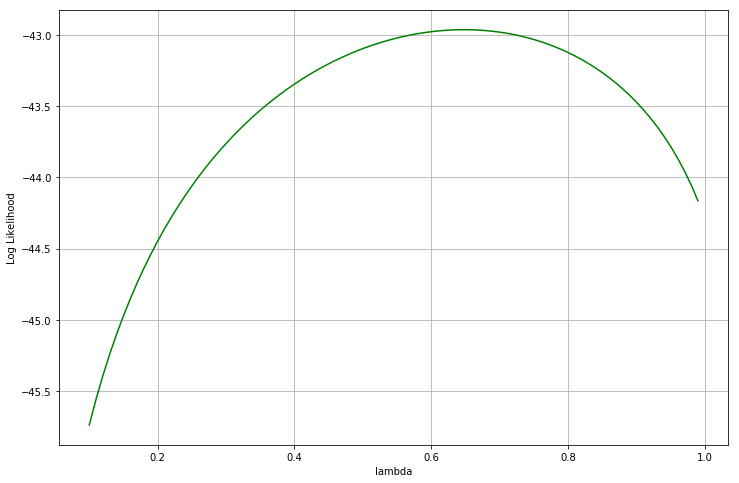

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.grid(True)
plt.xlabel("lambda")
plt.ylabel("Log Likelihood")
plt.plot(lam, mm_prob_lam, color='green')
plt.show()

**Optimal value of lambda**  
Following is the optimal value of lambda between [0,1] which gives the maximum log likelihood in our mixture model.

In [36]:
round(lam[mm_prob_lam.index(max(mm_prob_lam))],2)

0.65